In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Exercice 1 : Génération de poésie

# a) Génération des données et étiquettes

In [ ]:
bStart = False
fin = open("/content/gdrive/MyDrive/Tps_Deep/fleurs_mal.txt", 'r' , encoding = 'utf8')
lines = fin.readlines()
lines2 = []
text = []

for line in lines:
 line = line.strip().lower() # Remove blanks and capitals
 if("Charles Baudelaire avait un ami".lower() in line and bStart==False):
  print("START")
  bStart = True
 if("End of the Project Gutenberg EBook of Les Fleurs du Mal, by Charles Baudelaire".lower() in line):
  print("END")
  break
 if(bStart==False or len(line) == 0):
  continue
 lines2.append(line)

fin.close()
text = " ".join(lines2)
chars = sorted(set([c for c in text]))
nb_chars = len(chars)

START
END


In [ ]:
# mapping char -> index in dictionary: used for encoding (here)
char2index = dict((c, i) for i, c in enumerate(chars))
# mapping char -> index in dictionary: used for decoding, i.e. generation - part c)
index2char = dict((i, c) for i, c in enumerate(chars)) # mapping index -> char in dictionary

In [ ]:
import numpy as np
X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)

for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i][j][char2index[ch]]=True
        y[i][char2index[label_chars[i]]]=True

In [ ]:
import _pickle as pickle

ratio_train = 0.8
nb_train = int(round(len(input_chars)*ratio_train))
print("nb tot=",len(input_chars) , "nb_train=",nb_train)
X_train = X[0:nb_train,:,:]
y_train = y[0:nb_train,:]

X_test = X[nb_train:,:,:]
y_test = y[nb_train:,:]
print("X train.shape=",X_train.shape)
print("y train.shape=",y_train.shape)

print("X test.shape=",X_test.shape)
print("y test.shape=",y_test.shape)

outfile = "Baudelaire_len_"+str(SEQLEN)+".p"

with open(outfile, "wb" ) as pickle_f:
 pickle.dump( [index2char, X_train, y_train, X_test, y_test], pickle_f)

nb tot= 146166 nb_train= 116933
X train.shape= (116933, 10, 60)
y train.shape= (116933, 60)
X test.shape= (29233, 10, 60)
y test.shape= (29233, 60)


# b) Apprentissage d’un modèle auto-supervisé pour la génération de texte

In [ ]:
SEQLEN = 10
outfile = "Baudelaire_len_"+str(SEQLEN)+".p"
[index2char, X_train, y_train, X_test, y_test] = pickle.load( open( outfile, "rb" ) )

In [ ]:
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, RMSprop

model = Sequential()

#une couche récurrente
HSIZE = 128
model.add(SimpleRNN(HSIZE, return_sequences=False, input_shape=(SEQLEN, nb_chars),unroll=True))

#une couche complétement connecté 
model.add(Dense(nb_chars))
model.add(Activation("softmax"))


In [ ]:
#optimiser le modéle 
BATCH_SIZE = 128
NUM_EPOCHS = 50
learning_rate = 0.001
optim = RMSprop(lr=learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=optim,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128)               24192     
_________________________________________________________________
dense_1 (Dense)              (None, 60)                7740      
_________________________________________________________________
activation_1 (Activation)    (None, 60)                0         
Total params: 31,932
Trainable params: 31,932
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

scores_train = model.evaluate(X_train, y_train, verbose=1)
scores_test = model.evaluate(X_test, y_test, verbose=1)
print("PERFS TRAIN: %s: %.2f%%" % (model.metrics_names[1], scores_train[1]*100))
print("PERFS TEST: %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))

Epoch 1/50
914/914 [==============================] - 7s 7ms/step - loss: 2.6822 - accuracy: 0.2541
Epoch 2/50
914/914 [==============================] - 6s 6ms/step - loss: 2.1908 - accuracy: 0.3473
Epoch 3/50
914/914 [==============================] - 6s 6ms/step - loss: 2.1215 - accuracy: 0.3566
Epoch 4/50
914/914 [==============================] - 6s 6ms/step - loss: 2.0590 - accuracy: 0.3763
Epoch 5/50
914/914 [==============================] - 6s 6ms/step - loss: 2.0045 - accuracy: 0.3924
Epoch 6/50
914/914 [==============================] - 6s 6ms/step - loss: 1.9650 - accuracy: 0.4032
Epoch 7/50
914/914 [==============================] - 6s 6ms/step - loss: 1.9262 - accuracy: 0.4158
Epoch 8/50
914/914 [==============================] - 6s 6ms/step - loss: 1.8953 - accuracy: 0.4234
Epoch 9/50
914/914 [==============================] - 6s 6ms/step - loss: 1.8695 - accuracy: 0.4316
Epoch 10/50
914/914 [==============================] - 6s 6ms/step - loss: 1.8344 - accuracy: 0.4416

In [ ]:
from keras.models import model_from_yaml

def saveModel(model, savename):
  # serialize model to YAML
  model_yaml = model.to_yaml()
  with open(savename+".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    print ("Yaml Model ",savename,".yaml saved to disk")
  # serialize weights to HDF5
  model.save_weights(savename+".h5")
  print ("Weights ",savename,".h5 saved to disk")

In [ ]:
saveModel(model,'model_1')

Yaml Model  model_1 .yaml saved to disk
Weights  model_1 .h5 saved to disk


# c) Génération de texte avec le modèle appris

In [ ]:
SEQLEN = 10
outfile = "Baudelaire_len_"+str(SEQLEN)+".p"
[index2char, X_train, y_train, X_test, y_test] = pickle.load( open( outfile, "rb" ) )

In [ ]:
from keras.models import model_from_yaml
def loadModel(savename):
  with open(savename+".yaml", "r") as yaml_file:
    model = model_from_yaml(yaml_file.read())
  print("Yaml Model ",savename,".yaml loaded ")
  model.load_weights(savename+".h5")
  print ("Weights ",savename,".h5 loaded ")
  return model

In [ ]:
model = loadModel('model_1')
model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])
model.summary()
nb_chars = len(index2char)

Yaml Model  model_1 .yaml loaded 
Weights  model_1 .h5 loaded 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128)               24192     
_________________________________________________________________
dense_1 (Dense)              (None, 60)                7740      
_________________________________________________________________
activation_1 (Activation)    (None, 60)                0         
Total params: 31,932
Trainable params: 31,932
Non-trainable params: 0
_________________________________________________________________


In [ ]:
seed =15608
char_init = ""
for i in range(SEQLEN):
 char = index2char[np.argmax(X_train[seed,i,:])]
 char_init += char

print("CHAR INIT: "+char_init)

CHAR INIT: souvent, p


In [ ]:
test = np.zeros((1, SEQLEN, nb_chars), dtype=np.bool)
test[0,:,:] = X_train[seed,:,:]
preds = model.predict(test)[0]

In [ ]:
def sampling(preds, temperature=1.0):
  preds = np.asarray(preds).astype('float64')
  predsN = pow(preds,1.0/temperature)
  predsN /= np.sum(predsN)
  probas = np.random.multinomial(1, predsN, 1)
  return np.argmax(probas)


sampling(preds, temperature=0.01)


19

In [ ]:
nbgen = 400 # number of characters to generate (1,nb_chars)
gen_char = char_init
temperature  = 0.5

for i in range(nbgen):
 preds = model.predict(test)[0]  # shape (1,nb_chars)
 next_ind = sampling(preds,temperature)
 next_char = index2char[next_ind]
 gen_char += next_char
 for i in range(SEQLEN-1):
  test[0,i,:] = test[0,i+1,:]
 test[0,SEQLEN-1,:] = 0
 test[0,SEQLEN-1,next_ind] = 1

print("Generated text: "+gen_char)

Generated text: souvent, pour les paysil fentre en se serrive aux apileux la morte et de mon âme suis les font de désir actant encore se plus de sa jumeur des nuits, de tes des sont des imbues jette des choses le souveillesse d'une fait les poisser les yeux de son parcourie au dont des nuits d'autons que tout ce que tu francheur le lamme mains des vieux et leurs riens traînes de l'ariteur et le vin des chais des nuits d'un


# Exercice 2 : Embedding Vectoriel de texte

 # a/ extraction des embedding Glove des légendes

In [ ]:
import pandas as pd
filename = '/content/gdrive/MyDrive/Tps_Deep/flickr_8k_train_dataset.txt'

In [ ]:
df = pd.read_csv(filename, delimiter='\t')
nb_samples = df.shape[0]  #nombre d'échantillons

iter = df.iterrows()       #fonction d'iteration
allwords = []

for i in range(nb_samples):
    x=iter.__next__()
    cap_words = x[1][1].split() # split (divisé) caption into words
    cap_wordsl = [w.lower() for w in cap_words] # remove capital letters
    allwords.extend(cap_wordsl)
    
unique = list(set(allwords)) # List of different words in captions
print('taille de tous les mots ',len(unique)) 

taille de tous les mots  7707


In [ ]:
GLOVE_MODEL = "/content/gdrive/MyDrive/Tps_Deep/glove.6B.100d.txt"
fglove = open(GLOVE_MODEL, "r")


In [ ]:

import numpy as np
cpt=0
listembeddings=[]
listwords=[]
for line in fglove:
    row = line.strip().split()
    word=row[0]

    if(word in unique or word=='unk'):
        listwords.append(word)
  # embedding = COMPLETE WITH YOUR CODE - use a numpy array with dtype="float32"
        embedding=np.array(row[1:],dtype=np.float32)
        listembeddings.append(embedding)

        cpt +=1
        print("word: "+word+" embedded "+str(cpt))
     

fglove.close()
nbwords = len(listembeddings)
tembedding = len(listembeddings[0])
print("Number of words="+str(len(listembeddings))+" Embedding size="+str(tembedding))

word: the embedded 1
word: , embedded 2
word: . embedded 3
word: of embedded 4
word: to embedded 5
word: and embedded 6
word: in embedded 7
word: a embedded 8
word: " embedded 9
word: 's embedded 10
word: for embedded 11
word: - embedded 12
word: that embedded 13
word: on embedded 14
word: is embedded 15
word: was embedded 16
word: with embedded 17
word: he embedded 18
word: as embedded 19
word: it embedded 20
word: by embedded 21
word: at embedded 22
word: ( embedded 23
word: ) embedded 24
word: from embedded 25
word: his embedded 26
word: an embedded 27
word: be embedded 28
word: has embedded 29
word: are embedded 30
word: have embedded 31
word: but embedded 32
word: were embedded 33
word: not embedded 34
word: this embedded 35
word: who embedded 36
word: they embedded 37
word: had embedded 38
word: i embedded 39
word: which embedded 40
word: will embedded 41
word: their embedded 42
word: : embedded 43
word: or embedded 44
word: its embedded 45
word: one embedded 46
word: after embed

In [ ]:

print(listwords=='<start>')
len(listwords)

False


3038

In [ ]:
embeddings = np.zeros((len(listembeddings)+2,tembedding+2))
for i in range(nbwords):
 embeddings[i,0:tembedding] = listembeddings[i]


len(embeddings)  #3040 taille
listwords.append('<start>')
embeddings[3039,100] = 1
listwords.append('<end>')
#embeddings[3041,101] = 1

In [ ]:
embeddings.shape

(3040, 102)

In [ ]:
embeddings[:,:]

array([[-0.038194  , -0.24487001,  0.72812003, ...,  0.27061999,
         0.        ,  0.        ],
       [-0.10767   ,  0.11053   ,  0.59811997, ...,  0.082577  ,
         0.        ,  0.        ],
       [-0.33978999,  0.20941   ,  0.46348   , ..., -0.028803  ,
         0.        ,  0.        ],
       ...,
       [ 0.31169999,  0.41661999,  0.27146   , ..., -0.38683   ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
import _pickle as pickle

outfile = 'Caption_Embeddings.p'
with open(outfile, "wb" ) as pickle_f:
  pickle.dump( [listwords, embeddings], pickle_f)

# b/Analyse des embedding Glove des légendes

In [ ]:
import numpy as np
import _pickle as pickle

outfile = 'Caption_Embeddings.p'
[listwords, embeddings] = pickle.load( open( outfile, "rb" ) )
print("embeddings: "+str(embeddings.shape))

for i in range(embeddings.shape[0]):
 embeddings[i,:] /= np.linalg.norm(embeddings[i,:])

embeddings: (3040, 102)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [ ]:
embeddings

array([[-0.00656124, -0.04206555,  0.12508174, ...,  0.04648906,
         0.        ,  0.        ],
       [-0.01938821,  0.01990321,  0.10770387, ...,  0.0148697 ,
         0.        ,  0.        ],
       [-0.06223089,  0.03835242,  0.08488411, ..., -0.00527513,
         0.        ,  0.        ],
       ...,
       [ 0.0609767 ,  0.0815018 ,  0.0531047 , ..., -0.0756741 ,
         0.        ,  0.        ],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
embeddings.reshape(102,3039)

array([[-0.00656124, -0.04206555,  0.12508174, ..., -0.17474259,
        -0.06217878,  0.10478261],
       [-0.03666369, -0.17025798,  0.00731149, ..., -0.03559814,
         0.32616962,  0.09710436],
       [-0.05950138,  0.12809789, -0.07447901, ..., -0.00947719,
         0.00861278, -0.05448425],
       ...,
       [ 0.00659371,  0.23935887, -0.10127312, ..., -0.08975765,
        -0.01079347, -0.20230558],
       [ 0.00451549, -0.04247248,  0.18851752, ...,  0.12073089,
         0.09713568,  0.03080663],
       [-0.04112444,  0.06357968,  0.03490077, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
embeddings = embeddings[[~np.isnan(embeddings)]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


In [ ]:
embeddings=embeddings.reshape(3039,102)

In [ ]:
from sklearn.cluster import KMeans
kmeans =KMeans(n_clusters=10, init='random', max_iter=1000)
 # COMPLETE WITH YOUR CODE - apply fit() method on embeddings

kmeans.fit(embeddings)



KMeans(algorithm='auto', copy_x=True, init='random', max_iter=1000,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
clustersID  = kmeans.labels_
clusters = kmeans.cluster_centers_

In [ ]:
clusters.shape

(10, 102)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib
matplotlib.use('TKAgg')

import matplotlib.pyplot as plt
import matplotlib.cm as cm

indclusters=[]
for i in range(10):
  norm = np.linalg.norm((clusters[i] - embeddings),axis=1)
  inorms = np.argsort(norm)
  indclusters.append(inorms[:])

  print("Cluster "+str(i)+" ="+listwords[indclusters[i][0]])
  for j in range(1,21):
    print(" mot: "+listwords[indclusters[i][j]])

Cluster 0 =one
 mot: only
 mot: time
 mot: the
 mot: last
 mot: same
 mot: well
 mot: .
 mot: as
 mot: while
 mot: but
 mot: over
 mot: both
 mot: this
 mot: first
 mot: though
 mot: two
 mot: another
 mot: three
 mot: next
 mot: all
Cluster 1 =area
 mot: along
 mot: near
 mot: where
 mot: nearby
 mot: located
 mot: road
 mot: across
 mot: location
 mot: east
 mot: outside
 mot: city
 mot: part
 mot: park
 mot: building
 mot: main
 mot: town
 mot: areas
 mot: small
 mot: around
 mot: places
Cluster 2 =game
 mot: team
 mot: play
 mot: games
 mot: winning
 mot: second
 mot: straight
 mot: player
 mot: win
 mot: players
 mot: third
 mot: first
 mot: fourth
 mot: final
 mot: match
 mot: round
 mot: time
 mot: played
 mot: starting
 mot: finished
 mot: playing
Cluster 3 =rather
 mot: not
 mot: any
 mot: well
 mot: because
 mot: even
 mot: change
 mot: way
 mot: possible
 mot: that
 mot: need
 mot: take
 mot: both
 mot: though
 mot: this
 mot: taking
 mot: focus
 mot: would
 mot: without
 mo

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, verbose=2, init='pca', early_exaggeration=24)
points2D = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3039 samples in 0.041s...
[t-SNE] Computed neighbors for 3039 samples in 2.045s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3039
[t-SNE] Computed conditional probabilities for sample 2000 / 3039
[t-SNE] Computed conditional probabilities for sample 3000 / 3039
[t-SNE] Computed conditional probabilities for sample 3039 / 3039
[t-SNE] Mean sigma: 0.308601
[t-SNE] Computed conditional probabilities in 0.170s
[t-SNE] Iteration 50: error = 183.6322632, gradient norm = 0.2437364 (50 iterations in 2.183s)
[t-SNE] Iteration 100: error = 183.0618439, gradient norm = 0.2229737 (50 iterations in 3.209s)
[t-SNE] Iteration 150: error = 183.2464600, gradient norm = 0.2336989 (50 iterations in 3.230s)
[t-SNE] Iteration 200: error = 183.4418030, gradient norm = 0.2185615 (50 iterations in 3.119s)
[t-SNE] Iteration 250: error = 184.2398682, gradient norm = 0.1992571 (50 iterations in 2.931s)
[t-SNE] KL divergence after 250 it

In [ ]:
points2D.shape

(3039, 2)

In [ ]:
indclusters

[array([  45,   83,   74, ..., 2831, 1861, 3038]),
 array([ 195,  289,  274, ..., 2669, 3023, 3038]),
 array([ 156,  128,  224, ..., 2878, 1861, 3038]),
 array([ 556,   33,  115, ..., 2947, 3038, 1861]),
 array([  75,  443,  407, ..., 2665, 2933, 3038]),
 array([1663,  391, 1905, ..., 2944, 3038, 2482]),
 array([ 534,  648, 1077, ..., 2482, 1994, 3038]),
 array([ 344,  977,  123, ..., 3023, 3038, 1861]),
 array([ 296,  217,  126, ..., 2403, 1861, 3038]),
 array([ 126,  192,  180, ..., 3014, 1994, 3038])]

In [ ]:
indclusters[1][1]

289

In [ ]:
points2D[int(indclusters[1][0])]

array([-28.34667 ,  14.871508], dtype=float32)

In [ ]:
pointsclusters=list()
for i in range(10):
  pointsclusters.append(points2D[int(indclusters[i][0])])
  
pointsclusters

[array([  6.2870927, -15.051588 ], dtype=float32),
 array([-28.34667 ,  14.871508], dtype=float32),
 array([11.526131, 51.89247 ], dtype=float32),
 array([ 18.43821 , -23.926836], dtype=float32),
 array([ 47.708435, -13.443543], dtype=float32),
 array([-48.500523,  35.07028 ], dtype=float32),
 array([15.454712 ,  5.2917795], dtype=float32),
 array([-17.853086,  41.839893], dtype=float32),
 array([-35.503654, -22.14682 ], dtype=float32),
 array([  8.818766, -17.172176], dtype=float32)]

In [ ]:
pointsclusters=np.array(pointsclusters)
pointsclusters[:,0]

array([  6.2870927, -28.34667  ,  11.526131 ,  18.43821  ,  47.708435 ,
       -48.500523 ,  15.454712 , -17.853086 , -35.503654 ,   8.818766 ],
      dtype=float32)

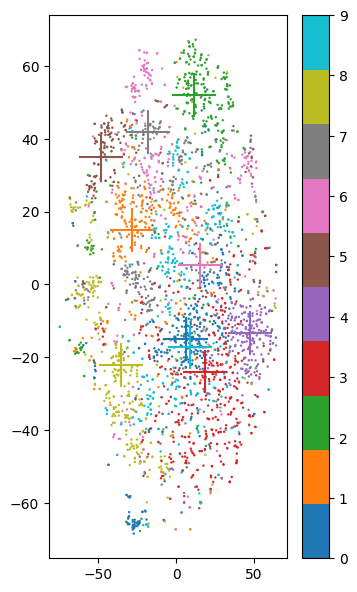

In [ ]:
#pointsclusters=np.array([])

#for i in range(10):
 #pointsclusters[i,:] = points2D[indclusters[i][0]]

cmap =cm.tab10
plt.figure(figsize=(3.841, 7.195), dpi=100)
plt.set_cmap(cmap)
plt.subplots_adjust(hspace=0.4 )
plt.scatter(points2D[:,0], points2D[:,1], c=clustersID,  s=3,edgecolors='none', cmap=cmap, alpha=1.0)
plt.scatter(pointsclusters[:,0], pointsclusters[:,1], c=range(10),marker = '+', s=1000, edgecolors='none', cmap=cmap, alpha=1.0)

plt.colorbar(ticks=range(10))
plt.show()